# Import libraries

In [0]:
import requests
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

#Collection data

In [175]:
# load the stock symbols into a data frame.
stock_symbols = pd.read_csv(r"stock_list.csv")

# we have a character that will cause issues in our request so we have to remove it
stock_symbols['Symbol'] = stock_symbols['Symbol'].str.replace('^','')

# display the number of rows.
display(stock_symbols.shape)

(5807, 1)

We have over 5800 stocks, so let them divide on chuncks for parallel loading from api td ameritrade

In [0]:
# define the size of the chunk
n = 100
# break the data frame into chunks
symbols_chunk = [stock_symbols[i:i+n] for i in range( 0, stock_symbols.shape[0], n)]

In [177]:
# grab an example so you can see the output
example_chunk = list(symbols_chunk[0]['Symbol'])

# show the first five items
example_chunk[:5]

['A', 'AA', 'AABA', 'AAC', 'AAL']

In [0]:
# define an endpoint, in this case we will use the instruments endpoint
endpoint = r"https://api.tdameritrade.com/v1/instruments"

# we need a place to store all of our data, so a dictionary will do.
stock_dict = {}

# loop through each chunk
for chunk in symbols_chunk:
    
    # define the payload
    payload = {'apikey':'LSVYWXHYOM22LARJV019FBURW85QBTG8',
               'projection':'fundamental',
               'symbol':list(chunk['Symbol'])}
    
    # make a request
    content = requests.get(url = endpoint, params = payload)

    # convert it dictionary object
    data = content.json()

    # the ones that do exist, loop through each stock, grab the data, and store it in the dictionary
    try:
        for stock in data:
            stock_dict[data[stock]['cusip']] = data[stock]['fundamental']
    except:
        continue


# create a data frame with the newly collected data.         
stock_df = pd.DataFrame(stock_dict)

For the most part, the data is in a perfect format. However, we need to do one other transformation that involves transposing it. This will make selecting the columns of interest easier.

In [179]:
# it's not in the right format, but if we transpose it we will have a much easier time grabbing the necessary columns.
stock_df = stock_df.transpose()

# display the head to make sure it's right
display(stock_df.head())

# let's recheck the shape, we lost a few hundred but this was expected as TD Ameritrade doesn't have data on every stock.
display(stock_df.shape)

,symbol,high52,low52,dividendAmount,dividendYield,dividendDate,peRatio,pegRatio,pbRatio,prRatio,pcfRatio,grossMarginTTM,grossMarginMRQ,netProfitMarginTTM,netProfitMarginMRQ,operatingMarginTTM,operatingMarginMRQ,returnOnEquity,returnOnAssets,returnOnInvestment,quickRatio,currentRatio,interestCoverage,totalDebtToCapital,ltDebtToEquity,totalDebtToEquity,epsTTM,epsChangePercentTTM,epsChangeYear,epsChange,revChangeYear,revChangeTTM,revChangeIn,sharesOutstanding,marketCapFloat,marketCap,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
037833100,AAPL,327.85,170.27,3.28,1.04,2020-05-08 00:00:00.000,24.6911,2.64576,17.3654,5.09418,19.8051,38.1098,38.3619,21.3504,19.2907,24.476,22.0414,62.094,17.2751,24.2163,1.46127,1.49596,0,58.4129,114.396,140.459,12.756,9.33233,3.83907,0,0,3.67171,0,4334.34,4320.97,1.36514e+06,1.38123,0,0,0,0.82,2020-08-14 00:00:00.000,1.1728,3.77217e+07,3.77217e+07,1.10888e+09
00773U108,ADVM,23.7899,4.96,0,0,,0,0,6.92312,5754.91,0,0,0,0,0,0,0,0,0,0,0,9.06173,0,0,0,0,0,15.252,0,0,0,0,0,79.9737,77.3013,1438.73,0,0,0,0,0,,2.13768,2.33725e+06,2.33725e+06,3.26934e+07
05464C101,AAXN,90.1,49.8,0,0,,0,0,5.29661,7.96588,366.551,58.159,60.2112,0,2.76838,0,0,0,0,0,2.93218,3.17279,0,0,0,0,0,0,0,0,0,29.3443,0,59.8252,58.7007,4478.52,41.5395,0,0,0,0,,0.72484,1.07385e+06,1.07385e+06,1.8301e+07
003881307,ACTG,3.5,1.75,0,0,,0,0,0.71937,9.63769,0,65.5902,88.8336,0,0,0,0,0,0,0,0,15.1634,0,0,0,0,0,67.4424,0,0,0,0,454.506,48.7058,46.1264,112.51,0,0,0,0,0,,0.5291,162330,162335,4.81575e+06
464288182,AAXJ,76.44,52.95,1.34375,2.06,2019-12-16 00:00:00.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,55.6,55.4677,3632.9,0,0,0,0,0.932597,2020-06-22 00:00:00.000,0.89076,1.39883e+06,1.39883e+06,3.75432e+07


(5082, 46)

# Select the Attributes/metrics
1. **Return on Assets:** Return on assets (ROA) is an indicator of how profitable a company is relative to its total assets. ROA gives a manager, investor, or analyst an idea as to how efficient a company’s management is at using its assets to generate earnings. Return on assets is displayed as a percentage.<br></br>


2. **Return on Equity:** Return on equity (ROE) is a measure of financial performance calculated by dividing net income by shareholders’ equity. Because shareholders’ equity is equal to a company’s assets minus its debt, ROE could be thought of as the return on net assets. ROE is considered a measure of how effectively management is using a company’s assets to create profits.


3. **Return on Investments:** Return on Investment (ROI) is a performance measure used to evaluate the efficiency of an investment or compare the efficiency of a number of different investments. ROI tries to directly measure the amount of return on a particular investment, relative to the investment’s cost. To calculate ROI, the benefit (or return) of an investment is divided by the cost of the investment. The result is expressed as a percentage or a ratio.

- https://www.researchgate.net/publication/4885243_Stock_selection_based_on_cluster_analysis
- https://www.researchgate.net/publication/316705565_The_Classification_of_Stocks_with_Basic_Financial_Indicators_An_Application_of_Cluster_Analysis_on_the_BIST_100_Index

In [180]:
# define our indicators list
metrics_list = ['returnOnEquity','returnOnAssets','returnOnInvestment','symbol']

# select only those columns
indicators_df = stock_df[metrics_list]

# display the unedited DF
display(indicators_df.head())

# clustering can't handle missing values, so we need to eliminate any row that has a missing value.
indicators_df = indicators_df[indicators_df[metrics_list] != 0]
indicators_df = indicators_df.dropna(how='any')

display(indicators_df.head())

,returnOnEquity,returnOnAssets,returnOnInvestment,symbol
037833100,62.094,17.2751,24.2163,AAPL
00773U108,0,0,0,ADVM
05464C101,0,0,0,AAXN
003881307,0,0,0,ACTG
464288182,0,0,0,AAXJ


,returnOnEquity,returnOnAssets,returnOnInvestment,symbol
037833100,62.094,17.2751,24.2163,AAPL
00770C101,18.7293,11.0008,14.1508,ADES
00081T108,15.5662,4.21122,5.13391,ACCO
006739106,5.55626,3.90461,4.49859,ADUS
01881G106,17.2864,17.2651,17.2651,AB


Next, to make things more manageable, let's set the `symbol` column as the data frame index. This will make selecting certain stock symbols much easier.

In [181]:
# set the index
indicators_df = indicators_df.set_index('symbol')

# do a data type conversion
indicators_df = indicators_df.astype('float')
backup_df = indicators_df
indicators_df.head()

,returnOnEquity,returnOnAssets,returnOnInvestment
symbol,,,
AAPL,62.09404,17.27511,24.21635
ADES,18.72930,11.00075,14.15080
ACCO,15.56620,4.21122,5.13391
ADUS,5.55626,3.90461,4.49859
AB,17.28643,17.26513,17.26513


#Remove Outliers
***
Averege got from those sites:
>*http://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/pbvdata.html*
>*http://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/pedata.html*


In [182]:
# define the filters
roe_filter = indicators_df.iloc[:,0] < 40
roa_filter = indicators_df.iloc[:,1] < 30
roi_filter = indicators_df.iloc[:,2] < 30

# get the counts for each column
roe_count = pd.Series(roe_filter).value_counts()
roa_count = pd.Series(roa_filter).value_counts()
roi_count = pd.Series(roi_filter).value_counts()

# display the results
display(roe_count)
display(roa_count)
display(roi_count)

True     1778
False     159
Name: returnOnEquity, dtype: int64

True     1902
False      35
Name: returnOnAssets, dtype: int64

True     1867
False      70
Name: returnOnInvestment, dtype: int64

In [183]:
# filter the entire data frame
indicators_df = indicators_df[roe_filter & roa_filter & roi_filter]

# display the results
indicators_df.head()

,returnOnEquity,returnOnAssets,returnOnInvestment
symbol,,,
ADES,18.72930,11.00075,14.15080
ACCO,15.56620,4.21122,5.13391
ADUS,5.55626,3.90461,4.49859
AB,17.28643,17.26513,17.26513
AC,6.80088,2.10367,2.43643


Okay, after removing some of these extreme values, we are now at an excellent spot to do a statistical summary of our data set. Use the `describe` method to create a summary data frame and then add a standard deviation metric that is calculated using the mean.

In [184]:
# create a statistical summary
desc_df = indicators_df.describe()

# add the standard deviation metric
desc_df.loc['+3_std'] = desc_df.loc['mean'] + (desc_df.loc['std'] * 3)
desc_df.loc['-3_std'] = desc_df.loc['mean'] - (desc_df.loc['std'] * 3)

# display it
desc_df

,returnOnEquity,returnOnAssets,returnOnInvestment
count,1758.000000,1758.000000,1758.000000
mean,12.195048,5.847018,7.338744
std,8.400196,4.677504,5.763949
min,0.018530,0.013910,0.015550
25%,5.792340,2.440967,2.989675
50%,10.582910,4.582060,5.941005
75%,16.668367,7.937753,9.963010
max,39.723530,28.589270,29.620160
+3_std,37.395637,19.879531,24.630592
-3_std,-13.005541,-8.185495,-9.953104


#Visualize & Scale the Data


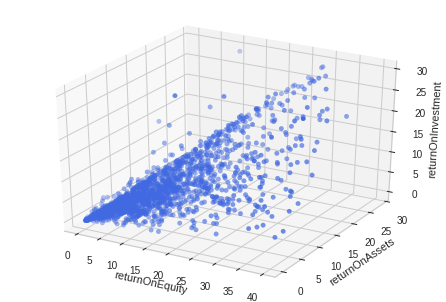

In [185]:


# define a figure and a 3D axis
fig = plt.figure()
ax = Axes3D(fig)

# define the x, y, & z of our scatter plot, this will just be the data from our data frame.
x = list(indicators_df.iloc[:,0])
y = list(indicators_df.iloc[:,1])
z = list(indicators_df.iloc[:,2])
x_b, y_b, z_b = x, y, z
# define the axis labels
column_names = indicators_df.columns
ax.set_xlabel(column_names[0])
ax.set_ylabel(column_names[1])
ax.set_zlabel(column_names[2])

# define the markers, and the color
ax.scatter(x, y, z, c='royalBlue', marker='o')

plt.show()

1. **Standard Scaler:** Here we subtract the mean from each data point and divide it by the standard deviation. This method is sensitive to outliers; however, like computing, the mean means taking the average of ALL data points, including the outliers.

2. **Min Max Scaler:** Here we scale the data so that it fits in a range between 0 and 1. Mathematically we take each data point, subtract the minimum from it, and then divide it by the difference of the maximum value and the minimum value. Again, this is sensitive to outliers as the maximum amount would be the outlier.

3. **Robust Scaler:** This method is a better choice if your data has outliers. With this method, we use the interquartile range instead of the minimum and maximum, which helps control for outliers.

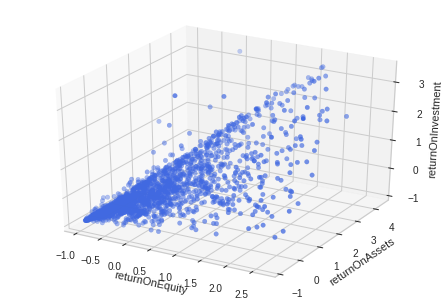

In [200]:

# for demonstration purposes, I will be creating all three instances of the scalers.
min_max_scaler = MinMaxScaler()
std_scaler = StandardScaler()
robust_scaler = RobustScaler()
# scale the data
X_train_minmax = min_max_scaler.fit_transform(indicators_df)
X_train_standard = std_scaler.fit_transform(indicators_df)
X_train_robust = robust_scaler.fit_transform(indicators_df)

# create a new plot
fig = plt.figure()
ax = Axes3D(fig)

# take the scaled data in this example.
x = X_train_robust[:,0]
y = X_train_robust[:,1]
z = X_train_robust[:,2]

# define the axes labels
column_names = indicators_df.columns
ax.set_xlabel(column_names[0])
ax.set_ylabel(column_names[1])
ax.set_zlabel(column_names[2])

# create a new plot
ax.scatter(x, y, z, c='royalBlue')

plt.show()

# Build & Run the Model


In [196]:
from sklearn.cluster import KMeans
from sklearn import metrics

# define a dictionary that contains all of our relevant info.
results_dict = {}

# define how many clusters we want to test up to.
num_of_clusters = 10

# run through each instance of K
for k in range(2, num_of_clusters):
    
    print("-"*100)
    
    # define the next dictionary to hold all the results of this run.
    results_dict[k] = {}

    # create an instance of the model, and fit the training data to it.
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_train_robust)
    
    # define the silhouette score
    sil_score = metrics.silhouette_score(X_train_robust, kmeans.labels_, metric='euclidean')
    
    # store the different metrics
    results_dict[k]['silhouette_score'] = sil_score
    results_dict[k]['inertia'] = kmeans.inertia_
    results_dict[k]['score'] = kmeans.score
    results_dict[k]['model'] = kmeans
    
    # print the results    
    print("Number of Clusters: {}".format(k))
    print('Silhouette Score:', sil_score)

----------------------------------------------------------------------------------------------------
Number of Clusters: 2
Silhouette Score: 0.5432605488808379
----------------------------------------------------------------------------------------------------
Number of Clusters: 3
Silhouette Score: 0.46445214319857664
----------------------------------------------------------------------------------------------------
Number of Clusters: 4
Silhouette Score: 0.41131051646494643
----------------------------------------------------------------------------------------------------
Number of Clusters: 5
Silhouette Score: 0.4270059105751635
----------------------------------------------------------------------------------------------------
Number of Clusters: 6
Silhouette Score: 0.39285339220311455
----------------------------------------------------------------------------------------------------
Number of Clusters: 7
Silhouette Score: 0.36582920244548384
------------------------------------

----------------------------------------------------------------------------------------------------


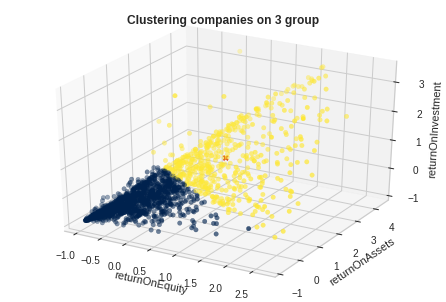

----------------------------------------------------------------------------------------------------


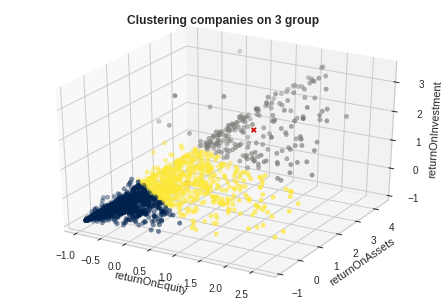

In [192]:
clusters = [2,3]

for cluster in clusters:
    
    print('-'*100)
    
    kmeans = KMeans(n_clusters= cluster, random_state=0).fit(X_train_robust)
    
    # define the cluster centers
    cluster_centers = kmeans.cluster_centers_
    C1 = cluster_centers[:, 0]
    C2 = cluster_centers[:, 1]
    C3 = cluster_centers[:, 2]


    # create a new plot
    fig = plt.figure()
    ax = Axes3D(fig)

    # take the scaled data in this example.
    x = X_train_robust[:,0]
    y = X_train_robust[:,1]
    z = X_train_robust[:,2]

    # define the axes labels
    column_names = indicators_df.columns
    ax.set_xlabel(column_names[0])
    ax.set_ylabel(column_names[1])
    ax.set_zlabel(column_names[2])

    # create a new plot
    ax.scatter(x, y, z, c = kmeans.labels_.astype(float), cmap='cividis')
    ax.scatter(C1, C2, C3, marker="x", color='r')

    plt.title('Clustering companies on 3 group', fontweight='bold')

    plt.show()

How should we interpret these results? Personally, when I saw the three cluster one, it made sense. We have some companies who perform horribly across all three metrics, that would be the dark blue region in the lower left-hand corner. We then have our average company, denoted by the color green; these are companies who might beat on some metrics, lose on some, or do average. Finally, we have our "show stoppers" these are companies denoted in light blue and represent the companies who are crushing every metric.

Again, there might be different ways to interpret these results, but for me it visually made sense, and while they might not have a nice spherical structure there is some type of grouping there albeit weak in some instances.

# Make Predictions



In [197]:
# grab the model

kmeans = results_dict[3]['model']

# define some test data
test_data = [[ 4.73620814,  2.30917709,  2.62074674],
 [-0.05359586,  0.98565616,  0.58207371],
 [-0.78915854, -0.46974004, -0.56515355]]
print(kmeans.predict(test_data))
# make some predictions, in this case let's pass through our test set.
backup_df["group"] = kmeans.predict(robust_scaler.transform(backup_df.loc[:, backup_df.columns !="group"]))
print(backup_df.to_string())

[1 2 0]
        returnOnEquity  returnOnAssets  returnOnInvestment  group
symbol                                                           
AAPL          62.09404        17.27511            24.21635      1
ADES          18.72930        11.00075            14.15080      2
ACCO          15.56620         4.21122             5.13391      2
ADUS           5.55626         3.90461             4.49859      0
AB            17.28643        17.26513            17.26513      1
AC             6.80088         2.10367             2.43643      0
AAP           13.71559         4.79956             8.16561      2
AAT            4.42256         2.43017             2.49001      0
ACLS           5.25698         4.01310             4.60151      0
A             15.45933         8.28050             9.87974      2
ABB            7.45060         2.13649             3.98012      0
ABC           48.60388         3.93800            16.49964      1
ABG           27.97083         5.45689             9.65811      2
AB